In [1]:
# --- NO TYPE 3 FONTS IN PDF OUTPUT ---
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.family"] = "DejaVu Sans"
mpl.rcParams["mathtext.fontset"] = "dejavusans"
mpl.rcParams["text.usetex"] = False

# Font sizes
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 12
# -------------------------------------

import imageio.v2 as imageio
from tqdm import trange

import os
import h5py
import yaml
import pickle
import shapely
import numpy as np
from utils import LatLonStandardScaler, StandardScaler

from sgptools.kernels import *
from sgptools.utils.gpflow import *
from sgptools.utils.metrics import *
from sgptools.utils.misc import *

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

2026-02-01 17:56:11.661622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-01 17:56:11.668839: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-01 17:56:11.751678: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-01 17:56:11.837848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769990171.922131    7494 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769990171.94

In [2]:
def cont2disc(
    Xu: np.ndarray,
    candidates: np.ndarray,
    candidate_labels: Optional[np.ndarray] = None
) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    """
    Maps continuous space locations (`Xu`) to the closest points in a discrete
    set of candidate locations (`candidates`) using a Hungarian algorithm
    (linear sum assignment) for optimal matching. This ensures each `Xu` point
    is matched to a unique candidate.

    Args:
        Xu (np.ndarray): (m, d); Continuous space points (e.g., optimized sensor locations).
                         `m` is the number of points, `d` is the dimensionality.
        candidates (np.ndarray): (n, d); Discrete set of candidate locations.
                                 `n` is the number of candidates, `d` is the dimensionality.
        candidate_labels (Optional[np.ndarray]): (n, 1); Optional labels corresponding to
                                                the discrete set of candidate locations.
                                                If provided, the matched labels are also returned.
                                                Defaults to None.

    Returns:
        Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        - If `candidate_labels` is None:
            np.ndarray: (m, d); Discrete space points' locations (`Xu_X`),
                        where each point in `Xu` is mapped to its closest
                        unique point in `candidates`.
        - If `candidate_labels` is provided:
            Tuple[np.ndarray, np.ndarray]: (`Xu_X`, `Xu_y`).
            `Xu_X` (np.ndarray): (m, d); The matched discrete locations.
            `Xu_y` (np.ndarray): (m, 1); The labels corresponding to `Xu_X`.

    Usage:
        ```python
        import numpy as np
        from sgptools.utils.misc import cont2disc

        # Example continuous points
        continuous_points = np.array([[0.1, 0.1], [0.9, 0.9], [0.5, 0.5]])
        # Example discrete candidates
        discrete_candidates = np.array([[0.0, 0.0], [1.0, 1.0], [0.4, 0.6]])
        # Example candidate labels (optional)
        discrete_labels = np.array([[10.0], [20.0], [15.0]])

        # 1. Map without labels
        mapped_points = cont2disc(continuous_points, discrete_candidates)

        # 2. Map with labels
        mapped_points_X, mapped_points_y = cont2disc(continuous_points, discrete_candidates, discrete_labels)
        ```
    """
    # Sanity check to handle empty inputs gracefully
    if len(candidates) == 0 or len(Xu) == 0:
        if candidate_labels is not None:
            return np.empty((0, Xu.shape[1])), np.empty((0, 1))
        else:
            return np.empty((0, Xu.shape[1]))
        
    # Compute pairwise Euclidean distances between candidates and Xu
    dists = pairwise_distances(candidates, Y=Xu, metric='euclidean')

    # Use the Hungarian algorithm (linear_sum_assignment) to find the optimal
    # assignment of rows (candidates) to columns (Xu points) that minimizes
    # the total cost (distances). `row_ind` gives the indices of the rows
    # (candidates) chosen, `col_ind` gives the corresponding indices of `Xu`.
    row_ind, col_ind = linear_sum_assignment(dists)

    # Select the candidate locations that were matched to Xu points
    Xu_X = candidates[row_ind].copy()

    if candidate_labels is not None:
        # If labels are provided, select the corresponding labels as well
        Xu_y = candidate_labels[row_ind].copy()
        return Xu_X, Xu_y, row_ind
    else:
        return Xu_X

In [3]:
mission_log = "../launch/data/asv"
num_samples = 5000
controller = "mavros"

# data file
fname = os.path.join(mission_log,
                     "mission-log.hdf5")

# load data
with h5py.File(fname, "r") as f:
    print(f.keys())
    fence_vertices = f["fence_vertices"][:].astype(float)
    X = f["X"][:].astype(float)
    y = f["y"][:].astype(float)

    X_candidates = f["X_objective"][:].astype(float)

    X_init = f["X_init"][:].astype(float)
    y_init = f["y_init"][:].astype(float)

    for key in f.keys():
        if 'initial' in key:
            initial_path = f[key][:].astype(float)
        elif 'coverage' in key:
            sol_path = f[key][:].astype(float)

print(f'Mission Log: {mission_log}')
print(f'Number of initial data samples: {X_init.shape[0]}')
print(f'Number of solution data samples: {X.shape[0]}')
print(f'Number of reconstruction samples: {num_samples}')

if controller == 'mavros':
    X_scaler = LatLonStandardScaler()
    X_scaler.fit(X_candidates)
elif controller == 'aqua2':
    X_scaler = StandardScaler()
    X_scaler.fit(X_candidates)

    # Change variance/scale parameter to ensure all axis are scaled to the same value
    ind = np.argmax(X_scaler.var_)
    X_scaler.var_ = np.ones(X.shape[-1])*X_scaler.var_[ind]
    X_scaler.scale_ = np.ones(X.shape[-1])*X_scaler.scale_[ind]
    X_scaler.scale_ /= 10.0  # Scale to ensure an extent of ~10 units

# Transform data
X_candidates = X_scaler.transform(X_candidates)
y_scaler = StandardScaler()
y_scaler.fit(y)

y = y_scaler.transform(y)
X = X_scaler.transform(X)

initial_path = X_scaler.transform(initial_path)
sol_path = X_scaler.transform(sol_path)
y_init = y_scaler.transform(y_init)
X_init = X_scaler.transform(X_init)
_, _, ind_init = cont2disc(initial_path, X_init, y_init)

fence_vertices = X_scaler.transform(fence_vertices)
sol_X, sol_y, ind = cont2disc(sol_path, X, y)

# Load aqua data
if controller == 'aqua2':
    fname = os.path.join(mission_log, "15-49.npy")
    data = np.load(fname)[280:2140]
    X_data = data[:, :2]
    y_data = data[:, 2].reshape(-1, 1)
    X_data_all = X_scaler.transform(X_data)
    y_data_all = y_scaler.transform(y_data)
elif controller == 'mavros':
    X_data_all = X
    y_data_all = y
X_data, y_data, ind_data = cont2disc(sol_path, X_data_all, y_data_all)

<KeysViewHDF5 ['X', 'X_init', 'X_objective', 'coverage_path-21-29-48', 'fence_vertices', 'initial_path-21-22-46', 'y', 'y_init']>
Mission Log: ../launch/data/asv
Number of initial data samples: 544
Number of solution data samples: 732
Number of reconstruction samples: 5000


In [4]:
# Compute grid
distance = 0.3
len_x = max(X_candidates[:, 0])-min(X_candidates[:, 0])
len_y = max(X_candidates[:, 1])-min(X_candidates[:, 1])
num_x = int(np.ceil(len_x/distance))
num_y = int(np.ceil(len_y/distance))
extent = [min(X_candidates[:, 0]), max(X_candidates[:, 0]), 
          min(X_candidates[:, 1]), max(X_candidates[:, 1])]
grid_x, grid_y = np.mgrid[extent[0]:extent[1]:complex(num_x), 
                          extent[2]:extent[3]:complex(num_y)]
X_grid = np.stack([grid_x, grid_y], axis=-1)
X_grid = X_grid.reshape(-1, 2).astype(X_candidates.dtype)

print(num_x, num_y)

# Remove sensing locations outside the boundaries
pbounds = shapely.geometry.Polygon(fence_vertices)
points = shapely.points(X_grid)
inside_idx = shapely.contains(pbounds, points)
outside_idx = np.logical_not(inside_idx)

136 90


In [5]:
# Extract hyperparameters details from config.yaml
config_fname = os.path.join(mission_log, f"config.yaml")
with open(config_fname, 'r') as file:
    config = yaml.safe_load(file)
hyperparameter_config = config.get('hyperparameters', {})
kernel = hyperparameter_config.get('kernel_function', 'RBF')

# Use float32 and higher jitter for deep learning model based kernel functions
if kernel in ['Attentive', 'NeuralSpectral']:
    gpflow.config.set_default_float(np.float32)
    gpflow.config.set_default_jitter(1e-1)
else:
    gpflow.config.set_default_float(np.float64)
    gpflow.config.set_default_jitter(1e-6)

kernel_kwargs = hyperparameter_config.get('kernel', {})
kernel = get_kernel(kernel)(**kernel_kwargs)
noise_variance = float(hyperparameter_config.get('noise_variance', 1e-4))
optimizer_kwargs = config.get('optimizer', {})

W0000 00:00:1769990175.606744    7494 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


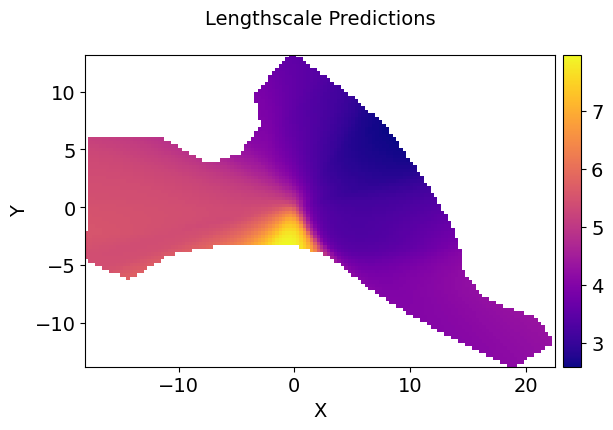

In [6]:
# ---- Plot lengthscale map ----
fig, ax = plt.subplots()

lengthscales = kernel.get_lengthscales(X_grid.astype(np.float32))
lengthscales[outside_idx] = np.nan

im = ax.imshow(
    lengthscales.reshape(num_x, num_y).T,
    origin='lower',
    extent=extent,
    cmap='plasma'
)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.08)  # tweak size/pad as desired
fig.colorbar(im, cax=cax)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Lengthscale Predictions\n')
fig.savefig("lengthscales", bbox_inches="tight")

plt.show()


Max Variance: 0.6518024


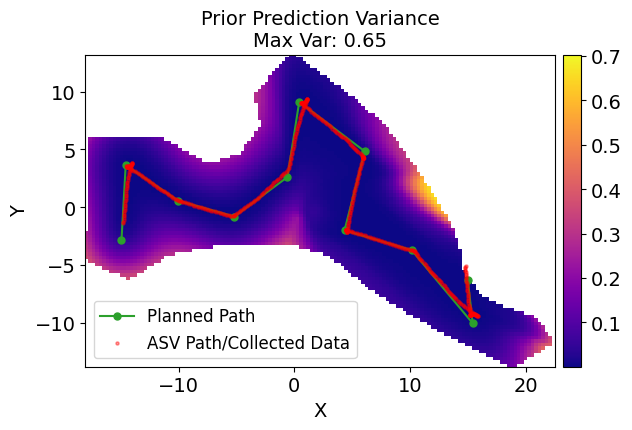

In [7]:
# Init GP model
_, _, _, gpr = get_model_params(np.vstack([X_init]).astype(np.float32), 
                                np.vstack([y_init]).astype(np.float32), 
                                kernel=kernel,
                                noise_variance=noise_variance,
                                return_model=True,
                                force_gp=True,
                                verbose=False,
                                max_steps=0)

# Load pre-trained parameters
fname = os.path.join(mission_log, f"model_params.pkl")
with open(fname, 'rb') as handle:
    params = pickle.load(handle)
gpflow.utilities.multiple_assign(gpr.kernel, params['kernel'])
gpflow.utilities.multiple_assign(gpr.likelihood, params['likelihood'])

mean, var_prior = gpr.predict_f(X_candidates.astype(np.float32))
print("Max Variance:", var_prior.numpy().max())

# ---- Plot variance map (prior) ----
fig, ax = plt.subplots()

_, var = gpr.predict_f(X_grid.astype(np.float32))
var = var.numpy()
var_min = var.min()
var_max = var.max()

var[outside_idx] = np.nan

im = ax.imshow(
    var.reshape(num_x, num_y).T,
    origin='lower',
    extent=extent,
    vmin=var_min, 
    vmax=var_max,
    cmap='plasma'
)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.08)  # tweak size/pad as desired
fig.colorbar(im, cax=cax)

if controller == 'mavros':
    ax.plot(initial_path[:, 0], initial_path[:, 1], c='C2', marker='o', markersize=5, label='Planned Path')
    ax.scatter(X_init[:, 0], X_init[:, 1], c='r', s=5, label='ASV Path/Collected Data', zorder=10, alpha=0.4)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc='lower left')
ax.set_title(f'Prior Prediction Variance\nMax Var: {var_prior.numpy().max():.2f}')
fig.savefig("prior", bbox_inches="tight")

plt.show()

Max Variance: 0.22934833


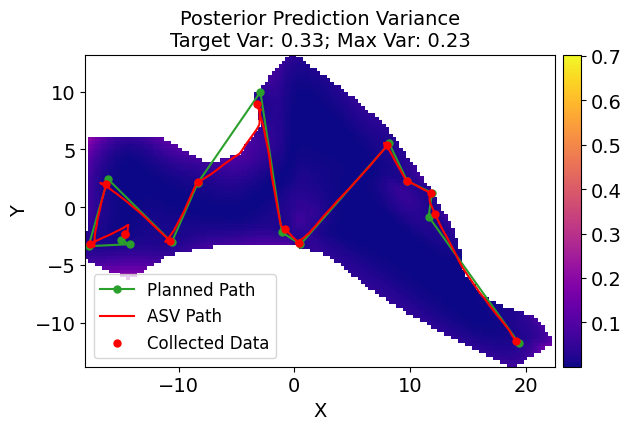

In [8]:
# Init GP model
_, _, _, gpr_post = get_model_params(np.vstack([X_init, X_data]).astype(np.float32), 
                                     np.vstack([y_init, y_data]).astype(np.float32), 
                                     kernel=kernel,
                                     noise_variance=noise_variance,
                                     return_model=True,
                                     force_gp=True,
                                     verbose=False,
                                     max_steps=0)

# Load pre-trained parameters
fname = os.path.join(mission_log, f"model_params.pkl")
with open(fname, 'rb') as handle:
    params = pickle.load(handle)
gpflow.utilities.multiple_assign(gpr_post.kernel, params['kernel'])
gpflow.utilities.multiple_assign(gpr_post.likelihood, params['likelihood'])

_, var_post = gpr_post.predict_f(X_candidates.astype(np.float32))
print("Max Variance:", var_post.numpy().max())

# ---- Plot variance map (posterior) ----

mean, var = gpr_post.predict_f(X_grid.astype(np.float32))
mean = mean.numpy()
var = var.numpy()
var[outside_idx] = np.nan

fig, ax = plt.subplots()

im = ax.imshow(
    var.reshape(num_x, num_y).T,
    origin='lower',
    extent=extent,
    vmin=var_min, 
    vmax=var_max,
    cmap='plasma'
)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.08)  # thickness + spacing
fig.colorbar(im, cax=cax)

ax.plot(sol_path[:, 0], sol_path[:, 1], c='C2', marker='o', markersize=5, label='Planned Path')
ax.plot(X_data_all[:, 0], X_data_all[:, 1], c='r', markersize=5, label='ASV Path', zorder=10, alpha=1)
ax.scatter(X_data[:, 0], X_data[:, 1], c='r', s=25, label='Collected Data', zorder=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc='lower left')
ax.set_title(f'Posterior Prediction Variance\nTarget Var: {var_prior.numpy().max()*0.5:.2f}; Max Var: {var_post.numpy().max():.2f}')
fig.savefig("posterior", bbox_inches="tight")

plt.show()

In [9]:
# %%
# ----------------------------
# CONFIG
# ----------------------------
fps = 12
out_mp4_prior = f"{controller}_prior.mp4"
out_mp4_post  = f"{controller}_posterior.mp4"

FIGSIZE = (7.2, 6.0)   # fixed canvas size
DPI = 150              # fixed DPI

X_grid_f32 = X_grid.astype(np.float32)
X_candidates_f32 = X_candidates.astype(np.float32)

TARGET_VAR = float(var_prior.numpy().max() * 0.5)

# ----------------------------
# GP + STATS HELPERS
# ----------------------------
def compute_variance_grid_flat(model):
    """Variance on grid as flat array with outside masked to NaN."""
    _, var = model.predict_f(X_grid_f32)
    var = var.numpy().reshape(-1)
    var[outside_idx] = np.nan
    return var

def compute_candidate_var_stats(model):
    """Mean/max variance on candidate set (for title text)."""
    _, v = model.predict_f(X_candidates_f32)
    v = v.numpy().reshape(-1)
    return float(np.mean(v)), float(np.max(v))

# ----------------------------
# RENDERING
# ----------------------------
def render_frame(
    var_flat,
    planned_path,
    asv_path_all,
    visited_waypoints=None,     # planned waypoints to reveal progressively (e.g., initial_path)
    visited_collected=None,     # collected data to reveal progressively (e.g., X_data)
    k=0, t=0,
    title_prefix="",
    var_mean=0.0,
    var_max=0.0,
    planned_label="Planned Path",
    visited_wp_label="Visited Waypoints",
    collected_label="Collected Data",
):
    """
    One frame:
      - variance heatmap
      - planned path (remaining from last visited wp)
      - ASV path (dense) + current ASV location
      - optionally: visited waypoints (subset of visited_waypoints[:k])
      - optionally: collected data (subset of visited_collected[:k])
    """
    asv_current = asv_path_all[t]

    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

    im = ax.imshow(
        var_flat.reshape(num_x, num_y).T,
        origin="lower",
        extent=extent,
        vmin=var_min,
        vmax=var_max,
        cmap="plasma",
    )
    ax.set_aspect("equal")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.08)
    fig.colorbar(im, cax=cax)

    # Planned path: show remaining segment starting at the last visited waypoint (or start)
    start_idx = max(k - 1, 0)
    ax.plot(
        planned_path[start_idx:, 0], planned_path[start_idx:, 1],
        c="w", marker="o", markersize=5, linewidth=2,
        label=planned_label, zorder=8
    )

    # Visited waypoints (subset of planned path)
    if visited_waypoints is not None and k > 0:
        ax.scatter(
            visited_waypoints[:k, 0], visited_waypoints[:k, 1],
            c="r", s=30, zorder=10,
            label=visited_wp_label
        )

    # Collected data points (subset of some data set, e.g., X_data)
    if visited_collected is not None and k > 0:
        ax.scatter(
            visited_collected[:k, 0], visited_collected[:k, 1],
            c="r", s=30, zorder=10,
            label=collected_label
        )

    # Current ASV location marker
    ax.scatter(
        asv_current[0], asv_current[1],
        s=120, c="white", edgecolor="black", linewidth=1.2,
        zorder=9, label="ASV Location"
    )

    # Clean look / green-screen background (your original aesthetic)
    ax.set_xlabel(None); ax.set_ylabel(None)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_frame_on(False)

    ax.set_title(
        f"{title_prefix}\n"
        f"Target Var: {TARGET_VAR:.2f}; Max Var: {var_max:.2f}; Mean Var: {var_mean:.2f}"
    )

    # De-duplicate legend labels
    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    uniq_h, uniq_l = [], []
    for h, lab in zip(handles, labels):
        if lab not in seen:
            uniq_h.append(h); uniq_l.append(lab); seen.add(lab)

    ax.legend(
        uniq_h, uniq_l,
        loc="lower left",
        bbox_to_anchor=(0.60, 0.73),
        facecolor="None",
        edgecolor="None"
    )

    fig.set_facecolor("#39FF14")
    ax.set_facecolor("#39FF14")
    fig.patch.set_alpha(1.0)
    ax.patch.set_alpha(1.0)

    fig.canvas.draw()
    rgba = np.asarray(fig.canvas.buffer_rgba())
    frame = rgba[..., :3].copy()
    plt.close(fig)
    return frame

def update_gp_prior_to_t_samples(t: int):
    """
    Update prior GP training data using X_init/y_init up to time t (inclusive).
    Uses at least 1 sample to avoid empty training sets.
    """
    n = int(t) + 1
    n = max(n, 1)
    n = min(n, len(X_init))

    X_train = np.asarray(X_init[:n], dtype=np.float32)
    y_train = np.asarray(y_init[:n], dtype=np.float32)
    gpr.data = (X_train, y_train)

def update_gp_to_k_waypoints(k: int):
    """Update posterior GP training data using waypoint/data up to k (k in [0..n_wp])."""
    if k <= 0:
        X_train = np.asarray(X_init, dtype=np.float32)
        y_train = np.asarray(y_init, dtype=np.float32)
    else:
        X_train = np.vstack([X_init, X_data[:k]]).astype(np.float32)
        y_train = np.vstack([y_init, y_data[:k]]).astype(np.float32)

    gpr_post.data = (X_train, y_train)

# ============================================================
# 1) PRIOR VIDEO
#   planned path = initial_path
#   ASV path      = X_init
#   visited wps   = driven by ind_init (mapping waypoint->time)
#   GP map        = updates with X_init/y_init over time
# ============================================================
planned_path_prior = np.asarray(initial_path)
asv_path_all_prior = np.asarray(X_init)
T_prior = len(asv_path_all_prior)
Nwp_prior = len(planned_path_prior)

# ind_init: length Nwp_prior, each entry is an index into X_init indicating
# when that planned waypoint is reached (Hungarian match).
ind_init = np.asarray(ind_init, dtype=int)
ind_init = np.clip(ind_init, 0, T_prior - 1)

# Build furthest visited waypoint index by time (monotone)
furthest_wp_idx_by_time = -np.ones(T_prior, dtype=int)
for wp_idx, t_idx in enumerate(ind_init):
    if wp_idx > furthest_wp_idx_by_time[t_idx]:
        furthest_wp_idx_by_time[t_idx] = wp_idx
furthest_wp_idx_by_time = np.maximum.accumulate(furthest_wp_idx_by_time)
furthest_wp_idx_by_time[furthest_wp_idx_by_time < 0] = 0

with imageio.get_writer(out_mp4_prior, fps=fps, codec="libx264", quality=8, format="FFMPEG") as writer:
    for t in trange(T_prior, desc="Rendering+encoding PRIOR (X_init timesteps)"):
        # Update GP with samples collected up to time t
        update_gp_prior_to_t_samples(t)

        # Recompute variance map + stats for the current prior GP
        var_flat_prior = compute_variance_grid_flat(gpr)
        prior_mean, prior_max = compute_candidate_var_stats(gpr)

        # Determine how many planned waypoints have been "visited" by time t
        furthest_wp = int(furthest_wp_idx_by_time[t])
        k = furthest_wp + 1

        frame = render_frame(
            var_flat=var_flat_prior,
            planned_path=planned_path_prior,
            asv_path_all=asv_path_all_prior,
            visited_waypoints=planned_path_prior,  # reveal initial_path[:k]
            visited_collected=None,
            k=k, t=t,
            title_prefix="Prediction Variance",
            var_mean=prior_mean,
            var_max=prior_max,
            planned_label="Planned Path",
            visited_wp_label="Visited Waypoints"
        )
        writer.append_data(frame)

print(f"Saved video: {out_mp4_prior}")

# ============================================================
# 2) POSTERIOR VIDEO
#   planned path = sol_path
#   ASV path      = X_data_all
#   visited pts   = X_data[:k] where k increases when ind_data reached
#   GP updates when a new waypoint is reached
# ============================================================
planned_path_post = np.asarray(sol_path)
asv_path_all_post = np.asarray(X_data_all)
T_post = len(asv_path_all_post)

# ind_data: indices in X_data_all when each solution waypoint is hit
ind_end = np.asarray(ind_data, dtype=int)
ind_end = np.clip(ind_end, 0, T_post - 1)
n_wp = len(X_data)

last_k = 0
update_gp_to_k_waypoints(last_k)
var_flat_post = compute_variance_grid_flat(gpr_post)
post_mean, post_max = compute_candidate_var_stats(gpr_post)

with imageio.get_writer(out_mp4_post, fps=fps, codec="libx264", quality=8, format="FFMPEG") as writer:
    for t in trange(T_post, desc="Rendering+encoding POSTERIOR (dense ASV timesteps)"):
        k = int(np.searchsorted(ind_end, t, side="right"))  # 0..n_wp

        if k != last_k:
            update_gp_to_k_waypoints(k)
            var_flat_post = compute_variance_grid_flat(gpr_post)
            post_mean, post_max = compute_candidate_var_stats(gpr_post)
            last_k = k

        frame = render_frame(
            var_flat=var_flat_post,
            planned_path=planned_path_post,
            asv_path_all=asv_path_all_post,
            visited_waypoints=None,
            visited_collected=X_data,   # reveal X_data[:k]
            k=k, t=t,
            title_prefix="Prediction Variance",
            var_mean=post_mean,
            var_max=post_max,
            planned_label="Planned Path",
            collected_label="Visited Waypoints"
        )
        writer.append_data(frame)
        
print(f"Saved video: {out_mp4_post}")


Rendering+encoding PRIOR (X_init timesteps): 100%|██████████| 544/544 [03:54<00:00,  2.32it/s]


Saved video: mavros_prior.mp4


Rendering+encoding POSTERIOR (dense ASV timesteps):   0%|          | 0/732 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1080, 900) to (1088, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Rendering+encoding POSTERIOR (dense ASV timesteps): 100%|██████████| 732/732 [00:41<00:00, 17.77it/s]

Saved video: mavros_posterior.mp4


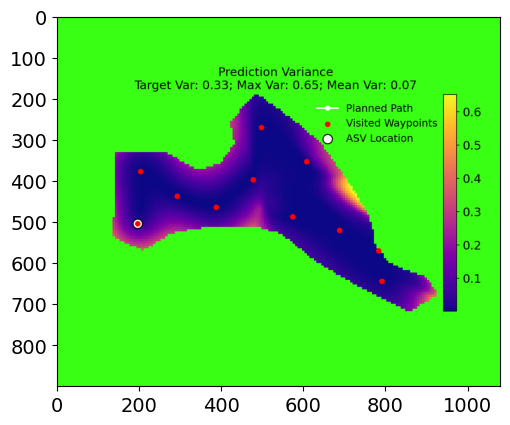

In [24]:
asv_path_all_prior[-1] = planned_path_prior[-1]
frame = render_frame(
    var_flat=var_flat_prior,
    planned_path=planned_path_prior,
    asv_path_all=asv_path_all_prior,
    visited_waypoints=planned_path_prior,  # reveal initial_path[:k]
    visited_collected=None,
    k=543, t=543,
    title_prefix="Prediction Variance",
    var_mean=prior_mean,
    var_max=prior_max,
    planned_label="Planned Path",
    visited_wp_label="Visited Waypoints"
)

plt.imshow(frame)
output_filename = 'last_init.png'
imageio.imwrite(output_filename, frame)